In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
from simtk import openmm as mm
from simtk.openmm import app
import simtk.unit as unit

# Two Lennard-Jones atoms in vacuum

## Ar-Ar

In [2]:
mass = 39.948 * unit.amu
sigma = 3.404 * unit.angstroms
epsilon = 0.238 * unit.kilocalories_per_mole

Reduced mass of a two particles system with masses $m_1$ and $m_2$:

\begin{equation}
m_{red} = \frac{m_1 * m_2}{m_1 + m_2}
\end{equation}

In [3]:
reduced_mass = (mass*mass) / (mass+mass)

Position of minimum:

\begin{equation}
x_{min} = 2^{1/6} \sigma
\end{equation}

In [4]:
x_min = 2**(1/6)*sigma

In [5]:
x_min

Quantity(value=3.8208608124451056, unit=angstrom)

Time period of small oscillations around the minimum:

\begin{equation}
\tau = \frac{\pi}{3·2^{1/3}} \sqrt{\frac{m\sigma^2}{\epsilon}}
\end{equation}

In [6]:
tau = (np.pi/(3*2**(1/3))) * np.sqrt((reduced_mass*sigma**2)/epsilon)
print(tau)

1.2671354578485272 ps


Potential energy surface:

In [7]:
system = mm.System()

non_bonded_force = mm.NonbondedForce()
non_bonded_force.setNonbondedMethod(mm.NonbondedForce.NoCutoff)

charge = 0.0 * unit.elementary_charge

# First Ar atom
system.addParticle(mass)
non_bonded_force.addParticle(charge, sigma, epsilon)

# Second Ar atom
system.addParticle(mass)
non_bonded_force.addParticle(charge, sigma, epsilon)

system.addForce(non_bonded_force)

integrator = mm.VerletIntegrator(2*unit.femtoseconds)
platform = mm.Platform.getPlatformByName('CUDA')

context = mm.Context(system, integrator, platform)

In [8]:
positions = np.zeros([2,3], float) * unit.angstroms

x = np.linspace(1.0, 8.0, 200, endpoint=True) * unit.angstroms
V = [] * unit.kilocalories_per_mole

for xi in x:
    positions[1,0] = xi
    context.setPositions(positions)
    state = context.getState(getEnergy=True)
    potential_energy = state.getPotentialEnergy()
    V.append(potential_energy)

In [9]:
def LJ (x, sigma, epsilon):
    
    t = sigma/x
    t6 = t**6
    t12 = t6**2
    
    return 4.0*epsilon*(t12-t6)

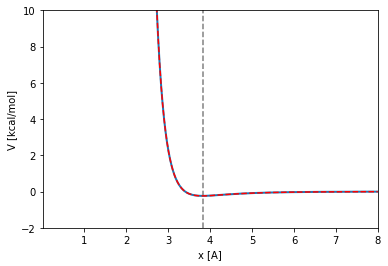

In [10]:
V._value = np.array(V._value)

xlim_figure = [0.01, 8.0]
ylim_figure = [-2.0, 10.0]

plt.plot(x, V, linewidth=2)
plt.plot(x, LJ(x, sigma, epsilon), linestyle='--', color='red')
plt.vlines(x_min._value, ylim_figure[0], ylim_figure[1], linestyles='dashed', color='gray')
plt.xlim(xlim_figure)
plt.ylim(ylim_figure)
plt.xlabel('x [{}]'.format(x.unit.get_symbol()))
plt.ylabel('V [{}]'.format(epsilon.unit.get_symbol()))
plt.show()

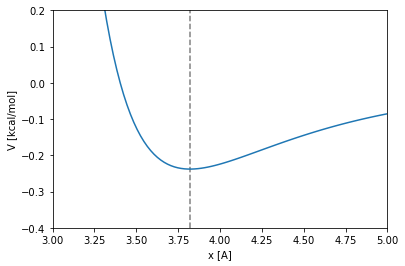

In [11]:
xlim_figure = [3.0, 5.0]
ylim_figure = [-0.4, 0.2]

x = np.linspace(xlim_figure[0], xlim_figure[1], 100, True) * unit.angstrom

plt.plot(x, LJ(x, sigma, epsilon))
plt.vlines(x_min._value, ylim_figure[0], ylim_figure[1], linestyles='dashed', color='gray')

plt.xlim(xlim_figure)
plt.ylim(ylim_figure)
plt.xlabel('x [{}]'.format(x.unit.get_symbol()))
plt.ylabel('V [{}]'.format(epsilon.unit.get_symbol()))
plt.show()

Deterministic dynamics simulation:

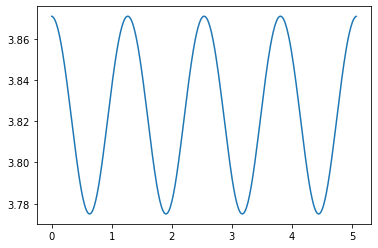

In [12]:
initial_distance = x_min + 0.05 * unit.angstroms
simulation_time = 4*tau
saving_time = 0.01*tau
integration_timestep = 0.01*tau

saving_steps = round(saving_time/integration_timestep)
n_savings = round(simulation_time/saving_time)

integrator = context.getIntegrator()
integrator.setStepSize(integration_timestep)

trajectory = []*unit.angstroms
times = []*unit.picoseconds

positions = np.zeros([2,3], float) * unit.angstroms
positions[1,0] = initial_distance
context.setPositions(positions)

velocities = np.zeros([2,3], float) * unit.angstroms/unit.picoseconds
context.setVelocities(velocities)

context.setTime(0.0*unit.picoseconds)

state = context.getState(getPositions=True)
positions = state.getPositions(asNumpy=True)
time = state.getTime()
distance = positions[1,0] - positions[0,0]
trajectory.append(distance)
times.append(time)

for _ in range(n_savings):
    
    integrator.step(saving_steps)
    state = context.getState(getPositions=True)
    positions = state.getPositions(asNumpy=True)
    time = state.getTime()
    distance = positions[1,0] - positions[0,0]
    trajectory.append(distance)
    times.append(time)

times._value = np.array(times._value)
trajectory._value = np.array(trajectory._value)

plt.plot(times, trajectory)
plt.show()

- Try to place the initial distance between the pair of atoms further than the simulated above. 

## Ar-Xe

In [13]:
mass_Ar = 39.948 * unit.amu
sigma_Ar = 3.404 * unit.angstroms
epsilon_Ar = 0.238 * unit.kilocalories_per_mole
charge_Ar = 0.0 * unit.elementary_charge

mass_Xe = 131.293 * unit.amu
sigma_Xe = 3.961 * unit.angstroms
epsilon_Xe = 0.459 * unit.kilocalories_per_mole
charge_Xe = 0.0 * unit.elementary_charge

Construction of sigma and epsilon:

\begin{equation}
\sigma = \frac{\sigma_{Ar}+\sigma_{Xe}}{2}
\end{equation}

\begin{equation}
\epsilon = \sqrt{\epsilon_{Ar} \epsilon_{Xe}}
\end{equation}

In [14]:
sigma = 0.5*(sigma_Ar+sigma_Xe)
epsilon = np.sqrt(epsilon_Ar*epsilon_Xe)

Reduced mass of a two particles system with masses $m_1$ and $m_2$:

\begin{equation}
m_{red} = \frac{m_{Ar} * m_{Xe}}{m_{Ar} + m_{Xe}}
\end{equation}

In [15]:
reduced_mass = (mass_Ar*mass_Xe) / (mass_Ar+mass_Xe)

Position of minimum:

\begin{equation}
x_{min} = 2^{1/6} \sigma
\end{equation}

In [16]:
x_min = 2**(1/6)*sigma

In [17]:
x_min

Quantity(value=4.133466492899267, unit=angstrom)

Time period of small oscillations around the minimum:

\begin{equation}
\tau = \frac{\pi}{3·2^{1/3}} \sqrt{\frac{m\sigma^2}{\epsilon}}
\end{equation}

In [18]:
tau = (np.pi/(3*2**(1/3))) * np.sqrt((reduced_mass*sigma**2)/epsilon)
print(tau)

1.4404534295370355 ps


In [19]:
system = mm.System()

non_bonded_force = mm.NonbondedForce()
non_bonded_force.setNonbondedMethod(mm.NonbondedForce.NoCutoff)

# Ar atom
system.addParticle(mass_Ar)
non_bonded_force.addParticle(charge_Ar, sigma_Ar, epsilon_Ar)

# Xe atom
system.addParticle(mass_Xe)
non_bonded_force.addParticle(charge_Xe, sigma_Xe, epsilon_Xe)

system.addForce(non_bonded_force)

integrator = mm.VerletIntegrator(2*unit.femtoseconds)
platform = mm.Platform.getPlatformByName('CUDA')

context = mm.Context(system, integrator, platform)

In [20]:
positions = np.zeros([2,3], float) * unit.angstroms

x = np.linspace(1.0, 8.0, 200, endpoint=True) * unit.angstroms
V = [] * unit.kilocalories_per_mole

for xi in x:

    positions[1,0] = xi
    context.setPositions(positions)
    state = context.getState(getEnergy=True)
    potential_energy = state.getPotentialEnergy()
    V.append(potential_energy)

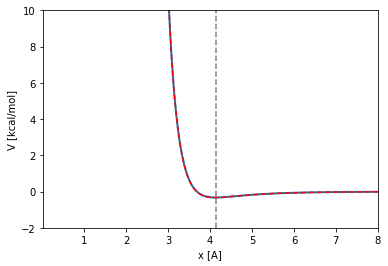

In [21]:
V._value = np.array(V._value)

xlim_figure = [0.01, 8.0]
ylim_figure = [-2.0, 10.0]

plt.plot(x, V, linewidth=2)
plt.plot(x, LJ(x, sigma, epsilon), linestyle='--', color='red')
plt.vlines(x_min._value, ylim_figure[0], ylim_figure[1], linestyles='dashed', color='gray')
plt.xlim(xlim_figure)
plt.ylim(ylim_figure)
plt.xlabel('x [{}]'.format(x.unit.get_symbol()))
plt.ylabel('V [{}]'.format(epsilon.unit.get_symbol()))
plt.show()

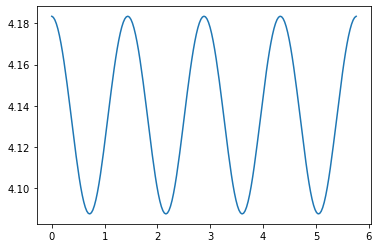

In [22]:
initial_distance = x_min + 0.05 * unit.angstroms
simulation_time = 4*tau
saving_time = 0.02*tau
integration_timestep = 0.01*tau

saving_steps = round(saving_time/integration_timestep)
n_savings = round(simulation_time/saving_time)

integrator = context.getIntegrator()
integrator.setStepSize(integration_timestep)

trajectory = []*unit.angstroms
times = []*unit.picoseconds

positions = np.zeros([2,3], float) * unit.angstroms
positions[1,0] = initial_distance
context.setPositions(positions)

velocities = np.zeros([2,3], float) * unit.angstroms/unit.picoseconds
context.setVelocities(velocities)

context.setTime(0.0*unit.picoseconds)

state = context.getState(getPositions=True)
positions = state.getPositions(asNumpy=True)
time = state.getTime()
distance = positions[1,0] - positions[0,0]
trajectory.append(distance)
times.append(time)

for _ in range(n_savings):

    integrator.step(saving_steps)
    state = context.getState(getPositions=True)
    positions = state.getPositions(asNumpy=True)
    time = state.getTime()
    distance = positions[1,0] - positions[0,0]
    trajectory.append(distance)
    times.append(time)

times._value = np.array(times._value)
trajectory._value = np.array(trajectory._value)

plt.plot(times, trajectory)
plt.show()

- Calcular la energía libre de unión del dímero

-------------

**Sources**

http://docs.openmm.org/6.3.0/userguide/theory.html#lennard-jones-interaction
https://openmmtools.readthedocs.io/en/0.18.1/api/generated/openmmtools.testsystems.LennardJonesPair.html
https://openmmtools.readthedocs.io/en/latest/api/generated/openmmtools.testsystems.LennardJonesFluid.html
https://gpantel.github.io/computational-method/LJsimulation/